1. Load Dataset

In [1]:
import torch
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


There are 30 features being monitored to detect breast cancer. Loading the dataset to get to know a bit about those variables:

In [2]:
import numpy
import pandas as pd

df = pd.read_csv('data.csv')

df.shape

(569, 33)

It is time to check unnecessary data. From the 33 columns of the dataset, ‘id’ and ‘Unnamed:32’ are dropped

In [3]:
df.drop(['id','Unnamed: 32'],axis=1,inplace=True)

Let's have a look at the whole dataset

In [6]:
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

2. Preparing the data

The values we want to predict are in the column ‘diagnosis’: these are the labels. We want to predict whether a tumor is malignant (‘M’) or benign (‘B). All the other columns in the data frame are the predictors/features for the model.

The labels are represented by letters M (malignant) and B (benign). First step is to transform this information into a numerical type of data, being 0 for benign and 1 for malignant:

In [9]:
lab ={'B':0,'M':1}
df = df.replace({'diagnosis':lab})
df.head()


TypeError: ignored

In [10]:
df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

Now the data can be split into two subsets.

predictors/Features — they are the information we will provide as input to the model to make the predictions

labels — the information we want to predict, which is whether given the information in the predictors dataset, the tumor is malignant or benign.

In [13]:
predictors = df.iloc[:, 2:31]
print(predictors)

labels = df.iloc[:, 0:1]
print(labels)

     texture_mean  perimeter_mean  ...  symmetry_worst  fractal_dimension_worst
0           10.38          122.80  ...          0.4601                  0.11890
1           17.77          132.90  ...          0.2750                  0.08902
2           21.25          130.00  ...          0.3613                  0.08758
3           20.38           77.58  ...          0.6638                  0.17300
4           14.34          135.10  ...          0.2364                  0.07678
..            ...             ...  ...             ...                      ...
564         22.39          142.00  ...          0.2060                  0.07115
565         28.25          131.20  ...          0.2572                  0.06637
566         28.08          108.30  ...          0.2218                  0.07820
567         29.33          140.10  ...          0.4087                  0.12400
568         24.54           47.92  ...          0.2871                  0.07039

[569 rows x 29 columns]
     diagnosis


Visualize the data

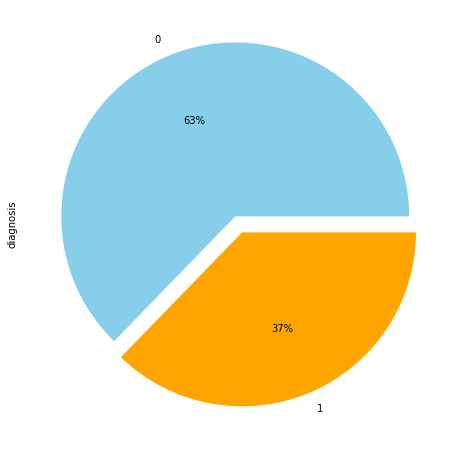

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df.diagnosis.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

Transformation to tensors and splitting the data into train and test subsets. Using scikit learn, the datasets were split into training and testing data, using a ratio of 20%.

In [21]:
from sklearn.model_selection import train_test_split
predictors_train, predictors_test, labels_train, labels_test = train_test_split(predictors,labels,test_size = 0.20)

Data Processing

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
predictors_train = scaler.fit_transform(predictors_train)
predictors_test = scaler.fit_transform(predictors_test)

As we will implement a deep learning model using Tensor Flow, the data must be transformed into tensors.

In [24]:
import numpy as np

predictors_train = torch.tensor(np.array(predictors_train), dtype=torch.float)
labels_train = torch.tensor(np.array(labels_train), dtype = torch.float).reshape(-1,1)
trainset = torch.utils.data.TensorDataset(predictors_train, labels_train)

predictors_test = torch.tensor(np.array(predictors_test), dtype=torch.float)
labels_test = torch.tensor(np.array(labels_test), dtype = torch.float).reshape(-1,1)
testset = torch.utils.data.TensorDataset(predictors_test, labels_test)

type(trainset)
type(testset)

torch.utils.data.dataset.TensorDataset

Pytorch trains the models in mini-batches. There is a class named DataLoader to perform the iterations on the dataset.

In [27]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=15, shuffle=True)
print(len(trainloader))
testloader = torch.utils.data.DataLoader(testset, batch_size=15, shuffle=True)
print(len(testloader))

31
8


3. Implementing and training the model

In [18]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.conv1 = nn.Linear(29,15)  #Number of features = 32-2-1
    self.conv2 = nn.Linear(15,15)  #hidden layer
    self.conv3 = nn.Linear(15,1)   

    self.dropout = nn.Dropout(p=0.2)

  def forward(self,x):
    x = x.view(x.shape[0],-1)

    x = self.dropout(F.relu(self.conv1(x)))
    x = self.dropout(F.relu(self.conv2(x)))
    #x = self.dropout(F.relu(self.conv3(x)))
    x = F.sigmoid(self.conv3(x))

    return x

In [35]:
model = Classifier()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007,weight_decay=0.0001)
#optimizer = torch.optim.Adam(model.parameters(), lr=.001)

model.train()
epoch =50
steps = 0
#train_losses = []
#test_losses = []

for e in range(epoch):
  running_loss = 0.0
  for predictors, labels in trainloader:  #batch loop
    optimizer.zero_grad()

    output = model(predictors)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    #running_loss += loss.data.item()
    running_loss += loss.item()*predictors.size(0)

  running_loss = running_loss / len(trainloader.dataset)
  print('Epoch: {} \t Training Loss: {: .6f}'.format(e+1, running_loss))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	 Training Loss:  0.671071
Epoch: 2 	 Training Loss:  0.612252
Epoch: 3 	 Training Loss:  0.553863
Epoch: 4 	 Training Loss:  0.477340
Epoch: 5 	 Training Loss:  0.384595
Epoch: 6 	 Training Loss:  0.301911
Epoch: 7 	 Training Loss:  0.237334
Epoch: 8 	 Training Loss:  0.194094
Epoch: 9 	 Training Loss:  0.156244
Epoch: 10 	 Training Loss:  0.138043
Epoch: 11 	 Training Loss:  0.129188
Epoch: 12 	 Training Loss:  0.109794
Epoch: 13 	 Training Loss:  0.095632
Epoch: 14 	 Training Loss:  0.083772
Epoch: 15 	 Training Loss:  0.088647
Epoch: 16 	 Training Loss:  0.077281
Epoch: 17 	 Training Loss:  0.077199
Epoch: 18 	 Training Loss:  0.081898
Epoch: 19 	 Training Loss:  0.070827
Epoch: 20 	 Training Loss:  0.079723
Epoch: 21 	 Training Loss:  0.071802
Epoch: 22 	 Training Loss:  0.057340
Epoch: 23 	 Training Loss:  0.066362
Epoch: 24 	 Training Loss:  0.057856
Epoch: 25 	 Training Loss:  0.061358
Epoch: 26 	 Training Loss:  0.058004
Epoch: 27 	 Training Loss:  0.061078
Epoch: 28 